# Actual Implementation

In [1]:
import train as T

In [2]:
# Configuration
sims = ['TNG50', 'TNG100', 'Eagle100', 'Simba100']
config = {
    'obs': 'mags',
    'train_sim': sims[:-1],
    'batch_size': 32,
    'num_epochs': 100,
    'lr': 0.001,
    'feature_layers': [128, 64, 32], 
    'label_layers': [32, 16, 8], 
    'domain_layers': [32, 16, 8], 
    'es_patience': 5,
    'es_min_delta': 0.005
}

# hyper parameters - priors
# alpha - 0 to 1e3 (log scale)
# lr - 0.01 to 2e-5 (log scale)

In [3]:
# Train
T.train_dann(config, use_wandb=False, plots=True)

/opt/homebrew/Caskroom/miniforge/base/envs/haloflow/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1:   5%|▌         | 38/743 [00:00<00:03, 217.08it/s]

tensor([[-1.3942,  0.3713],
        [-0.6787, -1.5183],
        [ 0.3588, -0.2218],
        [ 0.2868, -0.2269],
        [-0.0356, -0.3926],
        [ 0.0807, -0.0272],
        [ 0.3014, -0.2382],
        [ 0.3014, -0.2382],
        [-0.1825, -0.2444],
        [-0.3847,  0.5693],
        [ 0.3014, -0.2382],
        [-1.0550, -0.3243],
        [ 0.0571, -0.3929],
        [-0.0301, -0.0237],
        [ 0.1202, -0.4338],
        [ 0.2737, -0.3795],
        [ 0.3280, -0.2306],
        [-0.3394, -0.6547],
        [ 0.2815, -0.4571],
        [ 0.2418, -0.1087],
        [ 0.1679, -0.3254],
        [-1.0149, -0.4422],
        [ 0.1706, -0.4382],
        [ 0.2535, -0.5772],
        [-0.3766, -1.3848],
        [ 0.0066,  0.2665],
        [ 0.2108, -0.4376],
        [ 0.3431, -0.2263],
        [ 0.0186, -0.0077],
        [ 0.3014, -0.2382],
        [-0.7835, -0.2063],
        [ 0.2292, -0.3608]], grad_fn=<AddmmBackward0>)
tensor([[ 0.2255, -0.4227],
        [ 0.3691, -0.2781],
        [ 0.2380, -0.

Epoch 1:  14%|█▍        | 106/743 [00:00<00:02, 303.88it/s]

tensor([[ 0.1688,  0.1711],
        [ 0.2133, -0.2090],
        [ 0.5999, -0.1296],
        [ 0.1498, -0.0695],
        [ 0.1484, -0.0964],
        [ 0.1470, -0.3547],
        [-0.0745, -1.2075],
        [-1.1082,  0.7319],
        [ 0.4740, -0.0838],
        [ 0.4412, -0.1561],
        [ 0.6716, -0.1033],
        [ 0.4374,  0.0488],
        [ 0.7000, -0.0512],
        [ 0.3195, -0.1925],
        [ 0.4105, -0.1824],
        [ 0.0825,  0.2354],
        [-1.4449, -1.9608],
        [ 0.4761,  0.1667],
        [ 0.3071, -0.0811],
        [-0.0268,  0.4693],
        [ 0.0298,  0.2593],
        [ 0.2817, -0.0034],
        [ 0.3444, -0.1954],
        [ 0.1429,  0.5113],
        [ 0.3347, -0.0386],
        [-0.1109, -0.4086],
        [-0.9132,  1.4331],
        [-0.5153,  0.2630],
        [ 0.1489, -0.0782],
        [ 0.4292, -0.3652],
        [ 0.2192, -0.2914],
        [ 0.3523, -0.0790]], grad_fn=<AddmmBackward0>)
tensor([[ 0.4453, -0.1863],
        [-0.2444, -0.2397],
        [ 0.2486, -0.

Epoch 1:  23%|██▎       | 172/743 [00:00<00:01, 317.06it/s]

tensor([[ 0.3410,  0.0459],
        [ 0.3781,  0.4414],
        [-0.0316, -1.1722],
        [ 0.7484,  0.0889],
        [ 0.5757, -0.0199],
        [ 0.2898,  0.1510],
        [ 0.4734,  0.0601],
        [ 0.1878,  1.3407],
        [ 0.4125, -0.1273],
        [ 0.9433,  0.6604],
        [ 0.4845,  0.2215],
        [ 0.6254, -0.0348],
        [-0.1670,  0.7893],
        [ 0.7036,  1.1956],
        [ 0.7585,  0.3967],
        [ 0.3905,  0.1188],
        [ 0.7013,  0.6435],
        [ 0.6874,  0.5259],
        [ 0.5374,  0.2057],
        [ 0.1380,  0.9383],
        [ 0.2557, -0.0865],
        [ 0.4334,  0.4413],
        [ 0.7624,  0.0609],
        [ 0.8811,  0.8967],
        [-0.2633,  1.1875],
        [ 0.1081,  0.8751],
        [ 0.5935,  0.5598],
        [ 0.4125, -0.1273],
        [ 0.6694,  1.2682],
        [ 0.2753, -0.2805],
        [ 0.1047,  0.5108],
        [ 0.3958,  0.7169]], grad_fn=<AddmmBackward0>)
tensor([[ 0.7427,  0.3127],
        [ 0.2800,  0.4438],
        [ 0.0886,  0.

Epoch 1:  28%|██▊       | 205/743 [00:00<00:01, 319.14it/s]

tensor([[ 1.3472,  0.5148],
        [ 1.1070,  0.7250],
        [ 1.0765,  1.0081],
        [ 0.5105,  0.2340],
        [ 0.8878,  0.7400],
        [ 0.8168,  0.6712],
        [ 1.1421,  0.7258],
        [ 0.9060,  0.1982],
        [ 1.1259,  1.1842],
        [ 1.0740,  0.2913],
        [ 1.2326,  0.9032],
        [ 0.9705,  0.8473],
        [ 1.2401,  0.9463],
        [ 0.6454,  0.2750],
        [ 0.8475, -0.0437],
        [ 1.2166,  1.0519],
        [ 0.9424,  0.3943],
        [ 0.4288,  0.6886],
        [ 0.9213,  0.1266],
        [ 0.7376,  2.2230],
        [ 0.4309,  0.1666],
        [ 0.5329,  0.2464],
        [ 0.2843, -0.1096],
        [ 0.4645,  0.1858],
        [ 0.4000,  0.4541],
        [ 0.7446,  0.7027],
        [ 0.4080,  0.3941],
        [ 0.8508,  0.7566],
        [ 0.4745, -0.2202],
        [ 0.6078,  0.9003],
        [ 0.4400,  0.7536],
        [ 0.8640,  1.9231]], grad_fn=<AddmmBackward0>)
tensor([[ 0.3356,  1.5618],
        [ 0.2602,  1.3187],
        [ 1.0363,  0.

Epoch 1:  30%|███       | 225/743 [00:00<00:01, 265.74it/s]


tensor([[ 0.7513,  1.2325],
        [ 0.6285,  2.2712],
        [ 1.3113,  0.8363],
        [ 1.5170,  1.5368],
        [ 1.3236,  1.2625],
        [ 1.0894,  0.6529],
        [ 0.7693,  4.0370],
        [ 1.3031,  1.0748],
        [ 0.8032,  1.0482],
        [ 0.5223,  0.0092],
        [ 1.0958,  0.4219],
        [ 0.6254,  0.9727],
        [ 0.7594,  0.6813],
        [ 0.8278,  1.3414],
        [ 1.5885,  1.1914],
        [ 1.4843,  2.0132],
        [ 1.4755,  1.4514],
        [ 0.6887,  0.6462],
        [ 1.0501,  0.7204],
        [ 1.4233,  1.3370],
        [ 0.6054,  0.2947],
        [ 0.7634,  0.8207],
        [ 1.3668,  1.2290],
        [ 0.6184,  1.2836],
        [ 0.9065,  0.8367],
        [ 0.7753,  1.7757],
        [ 0.5833,  0.0079],
        [ 1.2963,  0.9880],
        [ 0.4952, -0.0311],
        [ 0.9590,  1.1303],
        [ 0.7577, -0.0581],
        [ 0.7992,  1.6302]], grad_fn=<AddmmBackward0>)
tensor([[ 0.8053,  0.7061],
        [ 1.7164,  1.4923],
        [ 0.6339,  0.

KeyboardInterrupt: 

# Priors

In [5]:
dat = dataset.data['TNG50']['Y_train']

NameError: name 'dataset' is not defined

In [ ]:
sm = dat[:, 0]
hm = dat[:, 1]

(6717, 2)


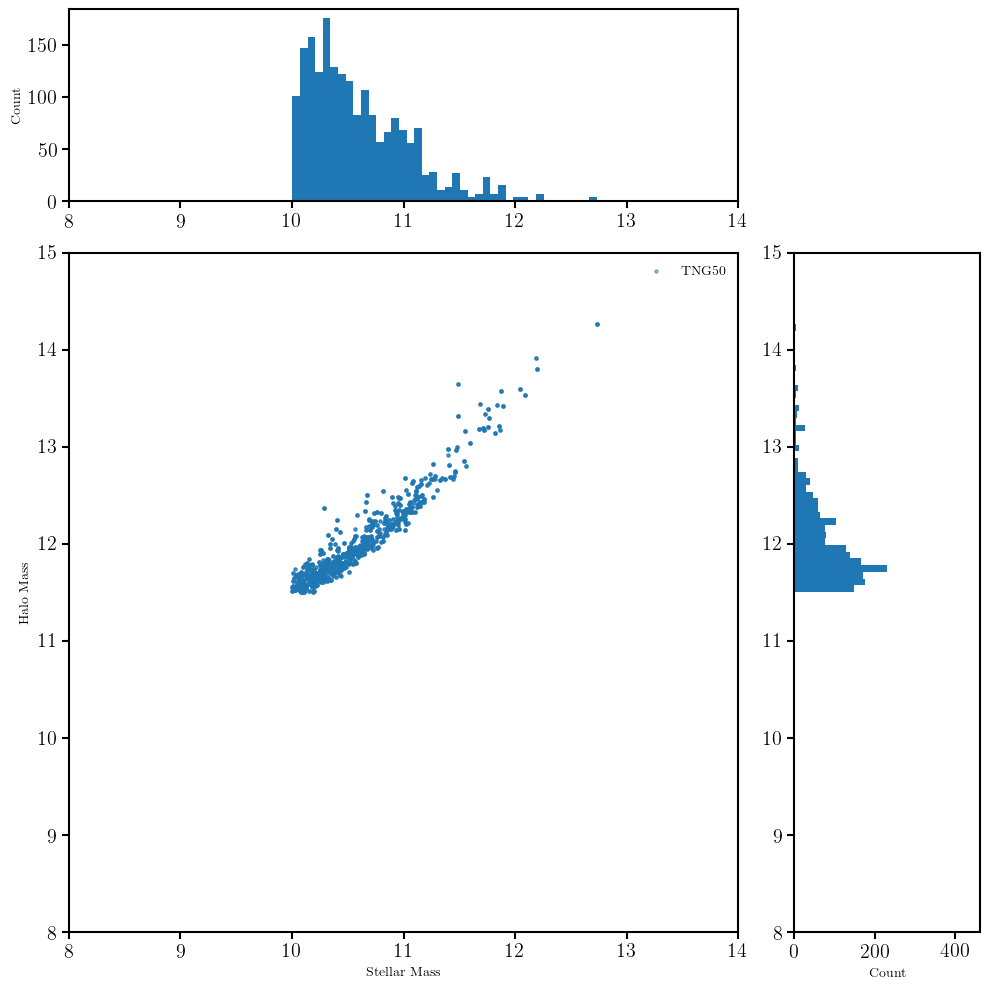

(13986, 2)


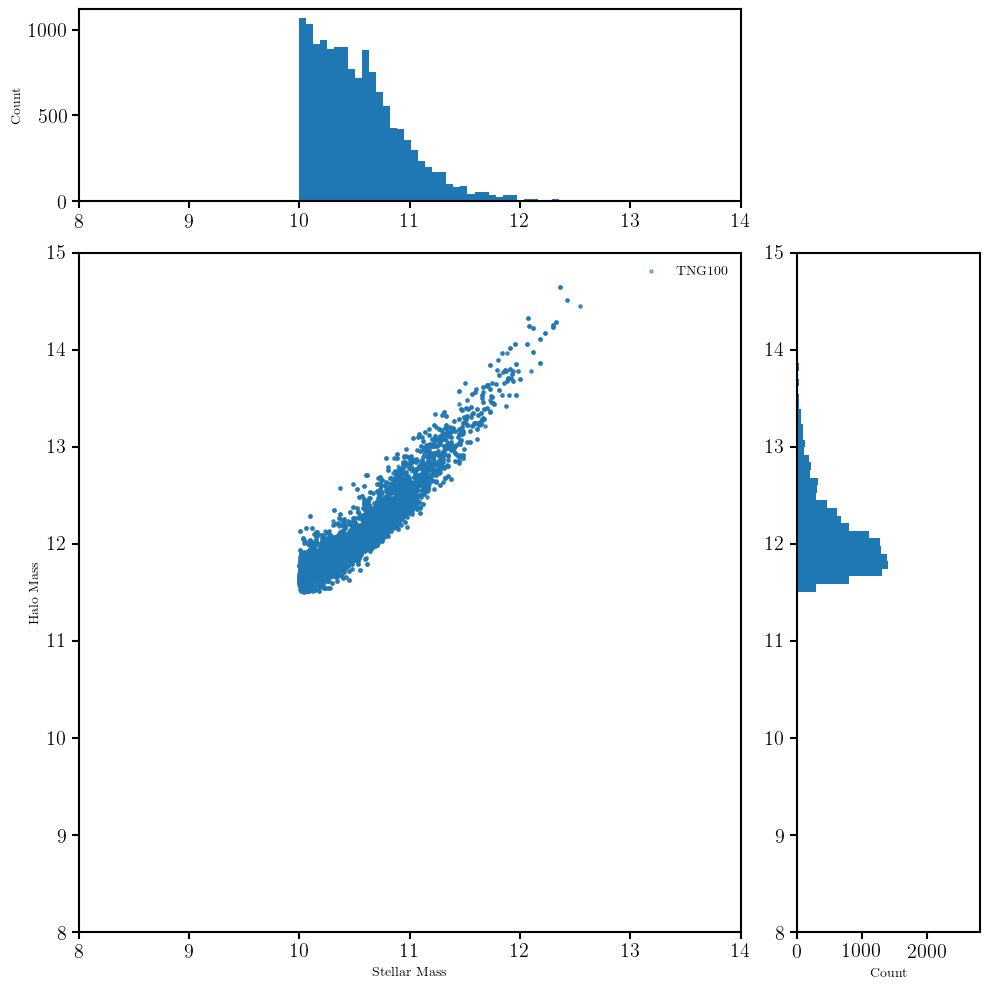

(8082, 2)


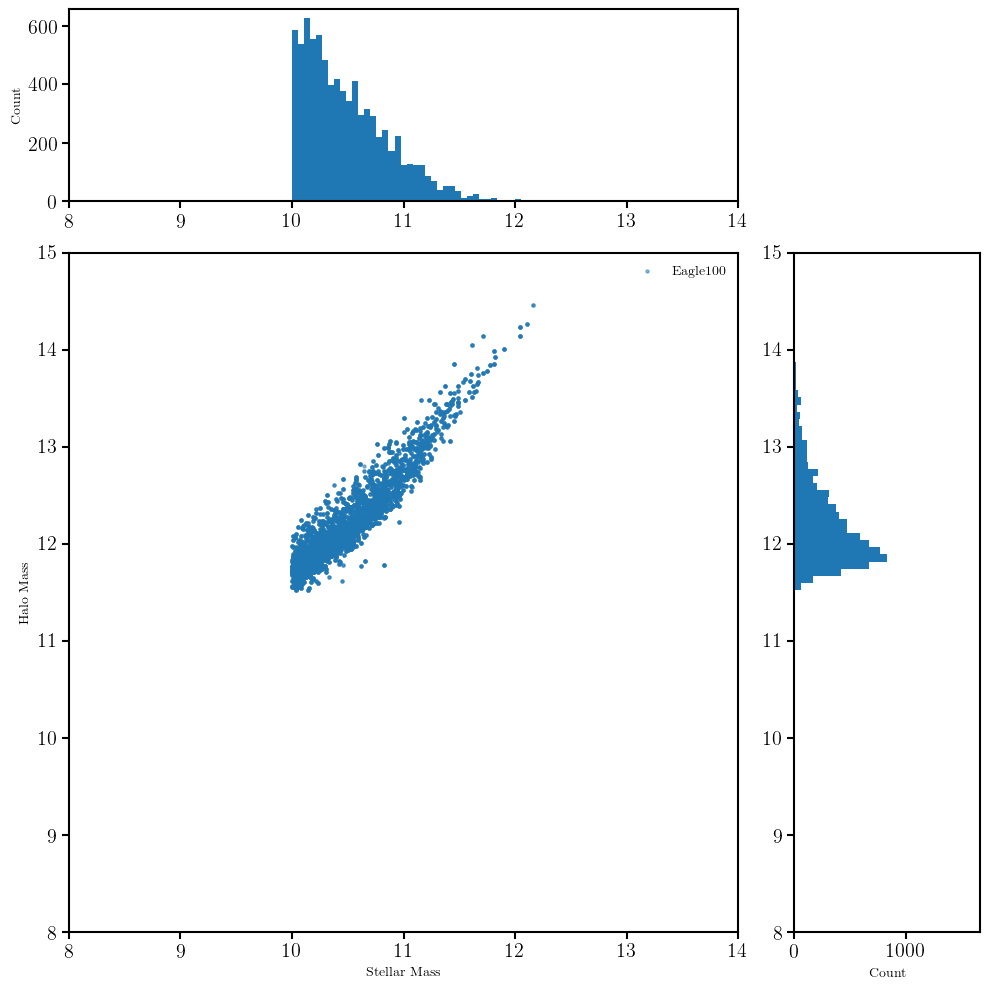

(8151, 2)


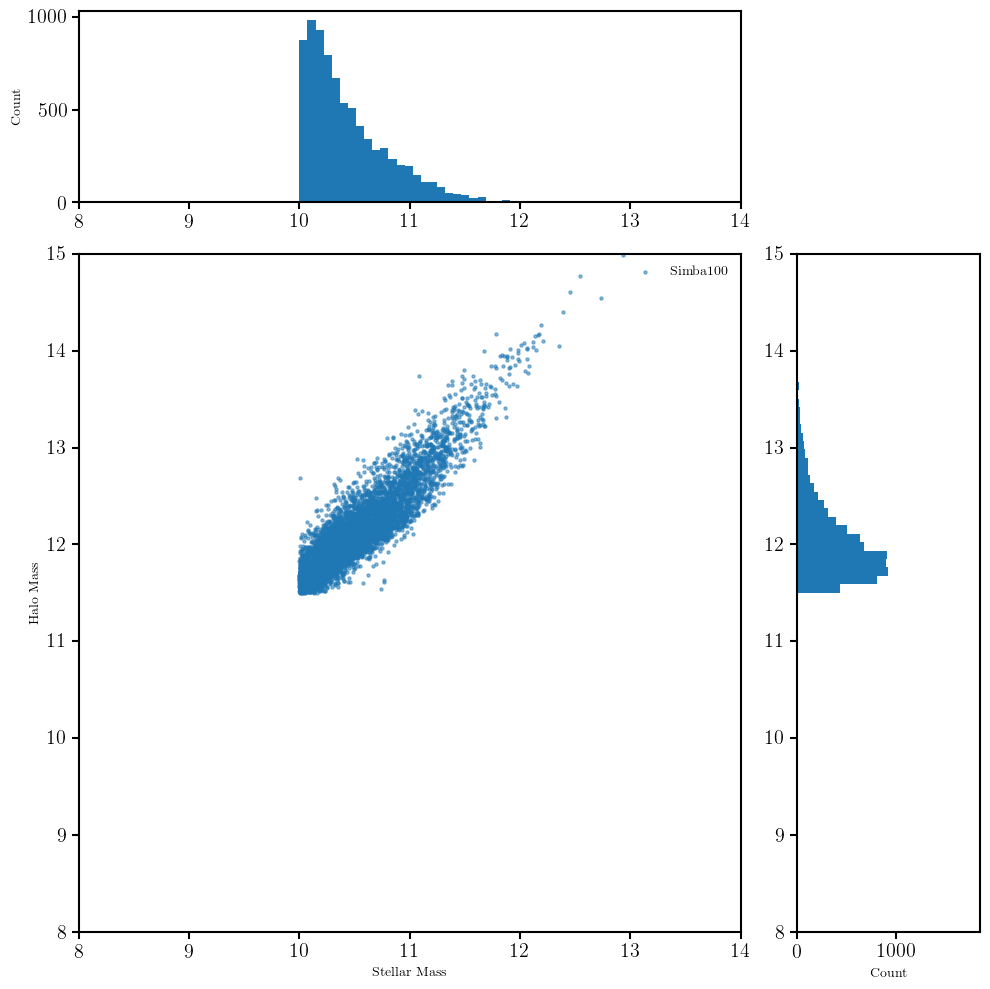

(20703, 2)


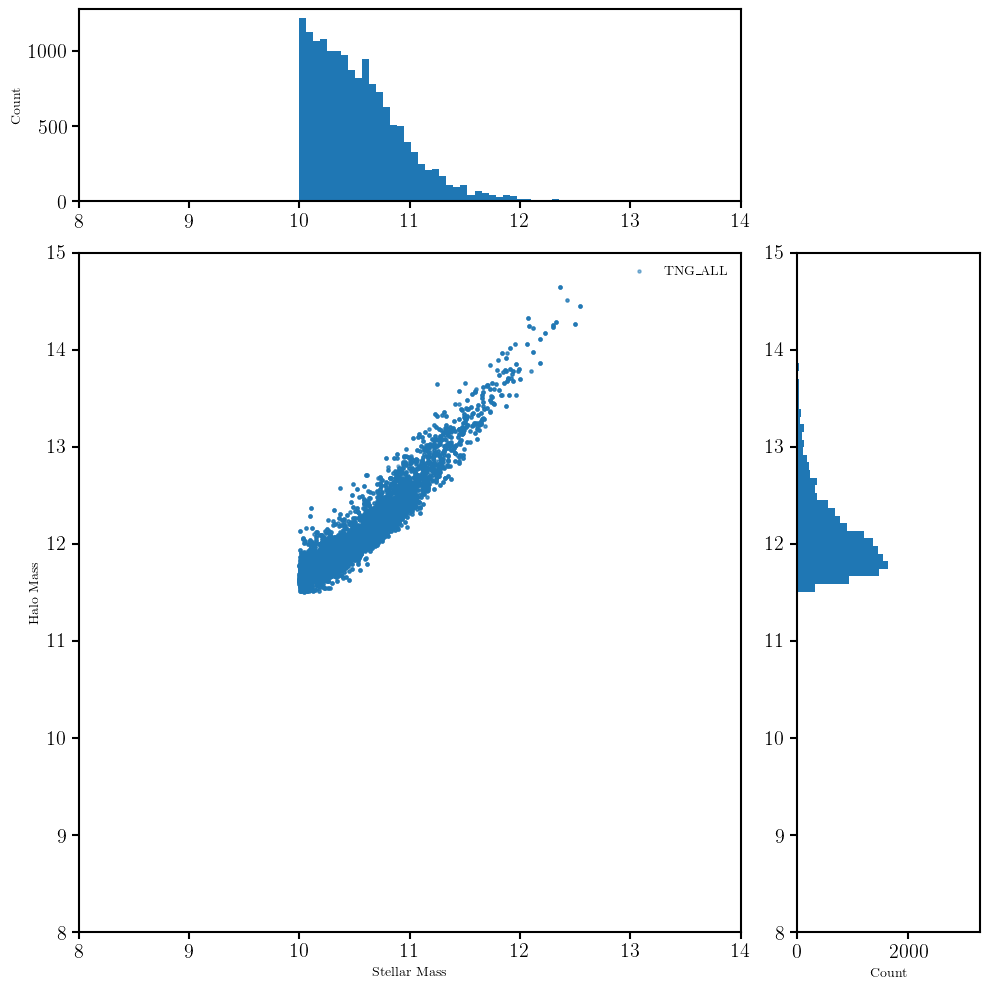

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

from haloflow.config import setup_plotting_config

setup_plotting_config()

for key in dataset.data.keys():
    # Example data
    dat = dataset.data[key]['Y_train']
    print(dat.shape)
    sm = dat[:, 0]
    hm = dat[:, 1]

#     mass_range_sm = [10.0, 13.]
#     mass_range_hm = [11.5, 15.]
#     mask_sm = (sm > mass_range_sm[0]) & (sm < mass_range_sm[1])
#     mask_hm = (hm > mass_range_hm[0]) & (hm < mass_range_hm[1])
#     sm = sm[mask_sm & mask_hm]
#     hm = hm[mask_sm & mask_hm]

    # Create the figure and grid layout
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(4, 4)

    # Main scatter plot
    ax_main = plt.subplot(gs[1:4, :3])

    ax_main.scatter(sm, hm, s=5, alpha=0.5, label=key)
    ax_main.set_xlabel('Stellar Mass')
    ax_main.set_ylabel('Halo Mass')
    ax_main.legend()

#     # Gray boxes outside the range
#     ax_main.axvspan(8, mass_range_sm[0], color='gray', alpha=0.5)
#     ax_main.axvspan(mass_range_sm[1], 15, color='gray', alpha=0.5)
#     ax_main.axhspan(9, mass_range_hm[0], color='gray', alpha=0.5)
#     ax_main.axhspan(mass_range_hm[1], 15, color='gray', alpha=0.5)

    # Set limits
    ax_main.set_xlim([8, 14])
    ax_main.set_ylim([8, 15])

    # Top histogram (stellar mass)
    ax_histx = plt.subplot(gs[0, :3], sharex=ax_main)
    ax_histx.hist(sm, bins=40, orientation='vertical')
    ax_histx.set_ylabel('Count')
    # ax_histx.set_xticks([])  # Remove x-ticks for the histogram

    # Right histogram (halo mass)
    ax_histy = plt.subplot(gs[1:4, 3], sharey=ax_main)
    ax_histy.hist(hm, bins=40, orientation='horizontal')
    ax_histy.set_xlabel('Count')
    # ax_histy.set_yticks([])  # Remove y-ticks for the histogram

    # Adjust layout
    plt.tight_layout()
    plt.show()

# test with the basic stuff

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

np.random.seed(23)

In [23]:
# random data (1, 2, 3, 4)
labels = [1, 2, 3, 4]

label_train = np.random.choice(labels, 100, replace=True) # truth
label_pred = np.random.choice(labels, 100, replace=True) # prediction

In [24]:
# make them tensors 
label_train = torch.tensor(label_train, dtype=torch.long)


In [25]:
(label_pred == label_train).sum().item() / len(label_train)

0.23

In [26]:
criterion_domain = nn.CrossEntropyLoss()

In [27]:
losses = []
for _ in range(100):
    label_pred = torch.tensor(label_pred, dtype=torch.long)
    # Convert label_pred to one-hot probabilities
    label_pred_one_hot = torch.zeros(len(label_pred), len(labels))
    label_pred_one_hot.scatter_(1, label_pred.unsqueeze(1) - 1, 1)  # subtract 1 since labels are 1-based
    loss = criterion_domain(label_pred_one_hot, label_train - 1)  # subtract 1 from target for 0-based indexing
    losses.append(loss.item())

/var/folders/1g/jdg8wj2j06g8cm00gnn6zvzc0000gn/T/ipykernel_16709/613041734.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_pred = torch.tensor(label_pred, dtype=torch.long)


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([1.01366818, 1.06366818, 1.11366818, 1.16366818, 1.21366818,
        1.26366818, 1.31366818, 1.36366818, 1.41366818, 1.46366818,
        1.51366818, 1.56366818, 1.61366818, 1.66366818, 1.71366818,
        1.76366818, 1.81366818, 1.86366818, 1.91366818, 1.96366818,
        2.01366818]),
 <BarContainer object of 20 artists>)

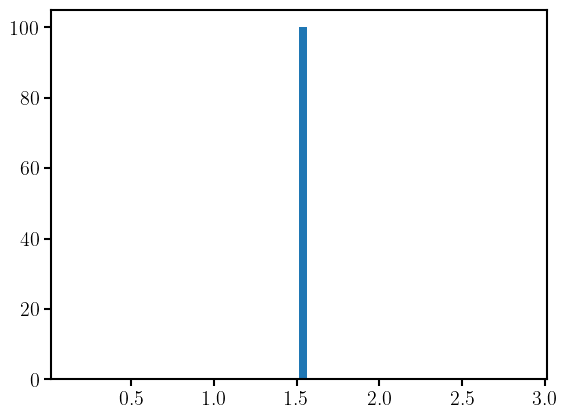

In [28]:
import matplotlib.pyplot as plt
plt.hist(losses, bins=20)